# Imports and Defines

## Imports
    Imports all modules and submodules that were necessary for this study.
    Special mention to TimeSeriesCrossValidation which was created with the purpose to be used in this thesis (https://github.com/DidierRLopes/TimeSeriesCrossValidation)

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as dr
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.gridspec as gridspec

from TimeSeriesCrossValidation import splitTrain
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import skewtest, kurtosistest, skew, kurtosis
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox, acorr_breusch_godfrey
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller, kpss, bds

import warnings
warnings.filterwarnings("ignore")

## Define Univariate Time-Series to study
    df: Dataframe with an index and a value column
    title: Title of data being used
    xlab: Label of df.index
    ylab: Label of df.values
    seasonal_periods: The repetition cycle
    
    stepsToForecast: Steps to forecast out-of-sample (and in-sample)

In [58]:
TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']
TS_print = []

previousStepsToShow = 15;
fittedValsToShow = 50;

stepsToForecast = [1, 3, 12];
df = dr.DataReader('CPIAUCSL', "fred", start='1947-01-01', end='2019-09-01')
df_train = df[['CPIAUCSL']][:-stepsToForecast[-1]].rename(columns={'CPIAUCSL': 'train'})
df_test = df[['CPIAUCSL']][-stepsToForecast[-1]:].rename(columns={'CPIAUCSL': 'test'})
title = 'CPIAUC'
xlab = 'Months/Year'; 
ylab = 'CPI: Index 1982-1984=100 (Seasonally Adjusted)';
seasonal_periods = 12

#stepsToForecast = [1, 5, 21];
#df = pd.read_csv("PSI_20_Data_1992_Stooq.csv") 
#df = pd.DataFrame(df, columns= ['Date','Close'])
#df.set_index('Date', drop=True, inplace=True)
#df.index = pd.to_datetime(df.index)
#df = df.truncate(before='2002-01-01', after='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'PSI20: Historical Closing Prices'
#xlab = 'Working Days/Year'; 
#ylab = 'Closing Price (Euro)';
#seasonal_periods = 5

#stepsToForecast = [1, 5, 21];
#df = dr.data.get_data_yahoo('SPY', start= '1993-01-01', end='2019-09-27')
#df_train = df[['Close']][:-stepsToForecast[-1]].rename(columns={'Close': 'train'})
#df_test = df[['Close']][-stepsToForecast[-1]:].rename(columns={'Close': 'test'})
#title = 'SP500'
#xlab = 'Days/Year'; 
#ylab = 'Closing Price ($)';
#seasonal_periods=5;

#stepsToForecast = [1, 3, 12];
#df = dr.DataReader("TRFVOLUSM227NFWA", "fred", start="1947-01-01", end="2019-09-01")
#df_train = df[['TRFVOLUSM227NFWA']][:-stepsToForecast[-1]].rename(columns={'TRFVOLUSM227NFWA': 'train'})
#df_test = df[['TRFVOLUSM227NFWA']][-stepsToForecast[-1]:].rename(columns={'TRFVOLUSM227NFWA': 'test'})
#title = "Vehicle Miles Traveled";
#xlab = "Months/Year";
#ylab = "Millions of Miles";
#seasonal_periods = 12

## Define functions
    Defines helper functions

In [183]:
# Compute MAE over an array of different horizons
def horizon_mae(y_true, y_pred, horizonSteps):
    ae  = abs(y_pred - y_true.T);
    list_MAE = list()
    for i in horizonSteps:
        list_MAE.append(round(np.mean(ae[0,:i]), 2))
    return list_MAE;

In [184]:
# Define Mean Absolute Percentage Error
def absolute_percentage_error(y_true, y_pred):
    if (len(y_true[y_true == 0])):
        print("Division by zero!")
        return None;
    else:
        return 100*(abs((y_pred - y_true.T) / y_true.T));

In [185]:
# Compute MAPE over an array of different horizons
def horizon_mape(y_true, y_pred, horizonSteps):
    ape = absolute_percentage_error(y_true, y_pred);
    if ape is not None:
        list_MAPE = list()
        for i in horizonSteps:
            list_MAPE.append(round(np.mean(ape[0,:i]), 2))
        return list_MAPE;

In [156]:
def ETS_plot(train, test, fit, forecast, title, xlab=xlab, ylab=ylab, previousStepsToShow=previousStepsToShow, stepsToForecast = stepsToForecast):
    plt.figure(figsize=(20,7))
    labels = ['Training and testing data', 'Fitted values', 'Predicted values']
    plt.title(title)
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, train[-previousStepsToShow:], 'k', linewidth = 3 )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, fit[-previousStepsToShow-1:-1], 'b--' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), forecast, 'r--*' , linewidth = 2 )
    plt.plot(1+np.arange(stepsToForecast[-1]), test, 'k-o' , linewidth = 3 )
    plt.legend(labels, loc='upper left')
    plt.grid(color='k', linestyle='--', linewidth=.2)
    plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
    plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
    plt.xlabel('Past and future working days')
    plt.ylabel(ylab)
    plt.show()

In [65]:
def ETS_fit_plot(train, fit, title, xlab=xlab, ylab=ylab, fittedValsToShow=fittedValsToShow):
    plt.figure(figsize=(20,7))
    labels = ['Training data', 'Fitted values']
    plt.title(title)
    plt.plot(1+np.arange(fittedValsToShow)-fittedValsToShow, train[-fittedValsToShow:], 'k', linewidth = 3 )
    plt.plot(1+np.arange(fittedValsToShow)-fittedValsToShow, fit[-fittedValsToShow:], 'b--' , linewidth = 2 )
    plt.legend(labels, loc='upper left')
    plt.grid(color='k', linestyle='--', linewidth=.2)
    plt.xlim([1-fittedValsToShow, 0])
    plt.xticks(1+np.arange(-fittedValsToShow, 0))
    plt.xlabel('Fitted Values to Training Data')
    plt.ylabel(ylab)
    plt.show()

# Data Visualization
    Check stationarity (mean and variance) through rolling mean and standard deviation. However, ETS models do not rely on data being stationary.

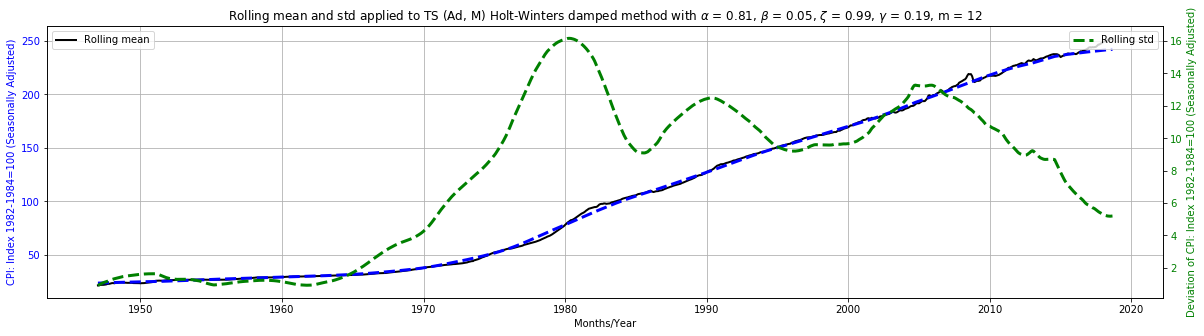

In [73]:
rolling_window = 100
rolling_mean = df_train.rolling(rolling_window, center=True, min_periods=1).mean() 
rolling_std  = df_train.rolling(rolling_window, center=True, min_periods=1).std() 

fig, axMean = plt.subplots(figsize=(20,5))

axMean.plot(df_train.index, df_train.values, label = df_train.columns.values[0], linewidth=2, color='black')
axMean.plot(rolling_mean, label='Rolling mean', linestyle='--', linewidth=3, color='blue')
axMean.set_xlabel(xlab)
axMean.legend(['Rolling mean'], loc='best')
axMean.set_ylabel(ylab, color='blue')
axMean.tick_params(axis='y', labelcolor='blue')

axStd = axMean.twinx()
axStd.plot(rolling_std, label='Rolling std', linestyle='--', linewidth=3, color='green')
axStd.set_ylabel(ylab)
axStd.legend(['Rolling std'], loc='best')
axStd.set_ylabel('Deviation of ' + ylab, color='green')
axStd.tick_params(axis='y', labelcolor='green')

axMean.set_title('Rolling mean and std applied to ' + title)
axMean.grid()
plt.show()

# Model Training
    This section will train the distinct Exponential Smoothing models and also show their fit to the Time-Series in order to understand their potential. 

## Single Exponential Smoothing

### TS (N, N) - Simple Exponential Smoothing

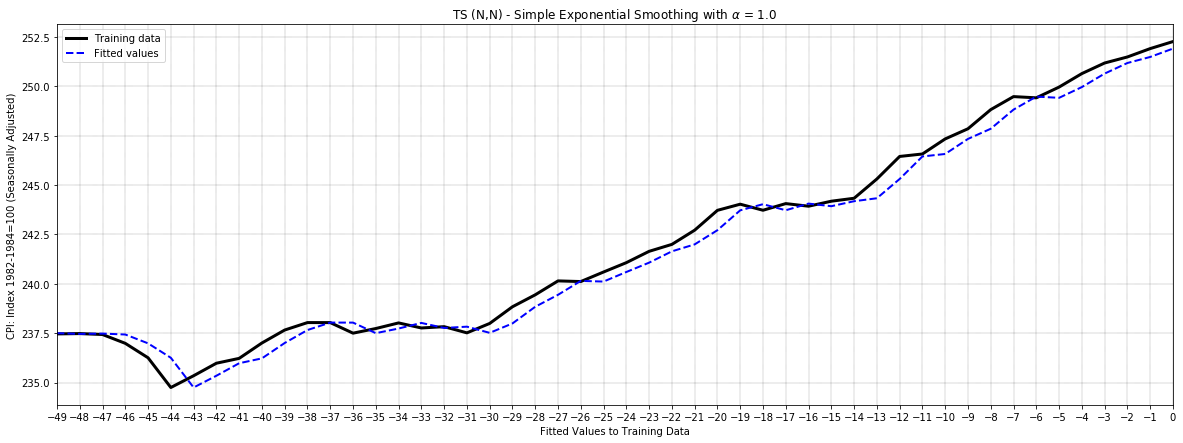

In [61]:
model_TS_NN = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False,
                                   seasonal=None)
TS_NN = model_TS_NN.fit(smoothing_level=None)

if (TS_NN.mle_retvals.success):
    TS_NN_forecast = TS_NN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N,N) - Simple Exponential Smoothing with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NN.params['smoothing_level'],2))
           
        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NN.fittedvalues, 
                     title = title)
        
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Double Exponential Smoothing

### TS (A, N) - Holt’s linear method

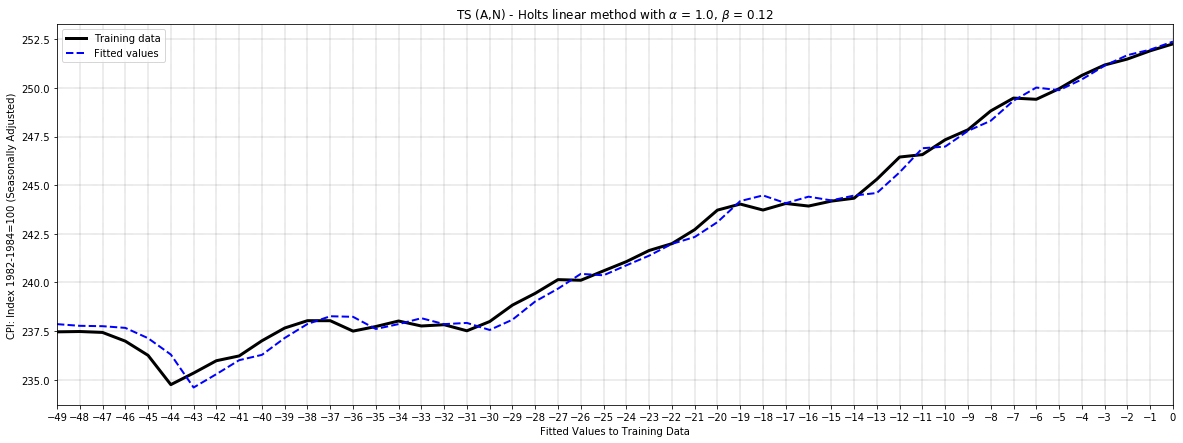

In [62]:
model_TS_AN = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False,
                                   seasonal=None)
TS_AN = model_TS_AN.fit(smoothing_level=None, 
                        smoothing_slope=None)

if (TS_AN.mle_retvals.success):
    TS_AN_forecast = TS_AN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A,N) - Holts linear method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AN.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AN.params['smoothing_slope'],2))

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AN.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, N) - Additive damped trend method

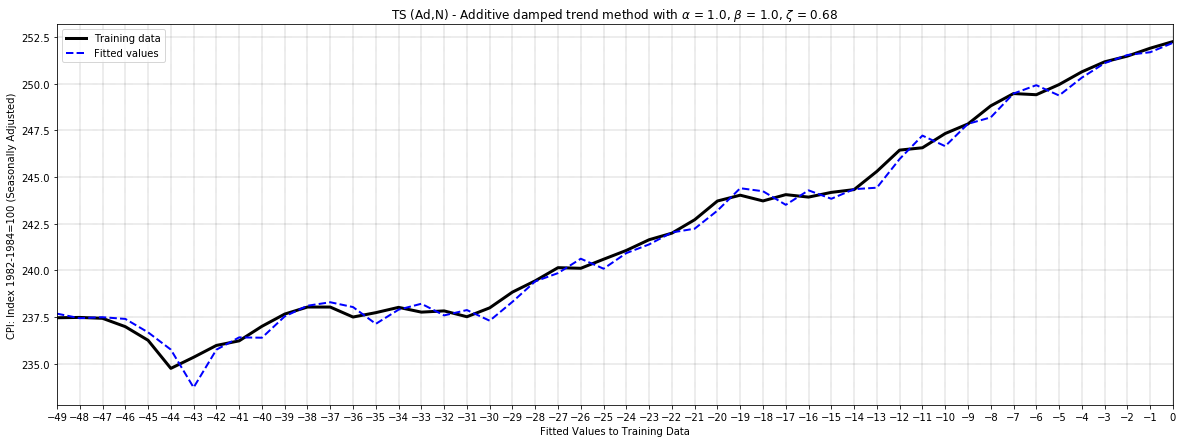

In [66]:
model_TS_AdN = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True,
                                    seasonal=None)
TS_AdN = model_TS_AdN.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None)

if (TS_AdN.mle_retvals.success):
    TS_AdN_forecast = TS_AdN.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdN_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad,N) - Additive damped trend method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdN.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdN.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdN.params['damping_slope'],2))

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdN.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

## Triple Exponential Smoothing

### TS (N, A) method

In [115]:
model_TS_NA = ExponentialSmoothing(df_train.values, 
                                   trend=None, 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_NA = model_TS_NA.fit(smoothing_level=None, 
                        smoothing_seasonal=None)

if (TS_NA.mle_retvals.success):
    TS_NA_forecast = TS_NA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_NA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, A) with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NA.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_NA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (A, A) - Additive Holt-Winters method

In [68]:
model_TS_AA = ExponentialSmoothing(df_train.values, 
                                   trend='add', 
                                   damped=False, 
                                   seasonal='add', 
                                   seasonal_periods=seasonal_periods)
TS_AA = model_TS_AA.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AA.mle_retvals.success):
    TS_AA_forecast = TS_AA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, A) - Additive Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AA.params['smoothing_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, A) method

In [69]:
model_TS_AdA = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='add', 
                                    seasonal_periods=seasonal_periods)
TS_AdA = model_TS_AdA.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdA.mle_retvals.success):
    TS_AdA_forecast = TS_AdA.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdA_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, A) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdA.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdA.params['damping_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AdA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdA.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (N, M) method

In [70]:
model_TS_NM = ExponentialSmoothing(df_train.values, 
                                    trend=None, 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_NM = model_TS_NM.fit(smoothing_level=None,  
                          smoothing_seasonal=None)

if (TS_NM.mle_retvals.success):
    TS_NM_forecast = TS_NM.forecast(stepsToForecast[-1])
    
    if (~np.isnan(TS_NM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (N, M) method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_NM.params['smoothing_level'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_NM.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_NM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (A, M) Multiplicative Holt-Winters’ method

In [71]:
model_TS_AM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=False, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AM = model_TS_AM.fit(smoothing_level=None, 
                        smoothing_slope=None, 
                        smoothing_seasonal=None)

if (TS_AM.mle_retvals.success):
    TS_AM_forecast = TS_AM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (A, M) Multiplicative Holt-Winters method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AA.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AA.params['smoothing_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AA.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AA.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

### TS (Ad, M) Holt-Winters’ damped method

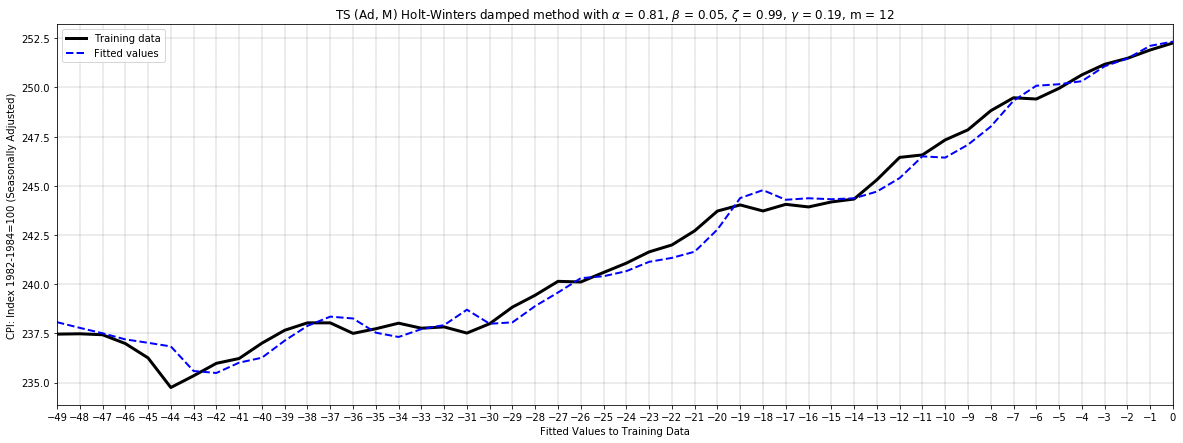

In [72]:
model_TS_AdM = ExponentialSmoothing(df_train.values, 
                                    trend='add', 
                                    damped=True, 
                                    seasonal='mul', 
                                    seasonal_periods=seasonal_periods)
TS_AdM = model_TS_AdM.fit(smoothing_level=None, 
                          smoothing_slope=None, 
                          damping_slope=None, 
                          smoothing_seasonal=None)

if (TS_AdM.mle_retvals.success):
    TS_AdM_forecast = TS_AdM.forecast(stepsToForecast[-1])

    if (~np.isnan(TS_AdM_forecast).any()):
        TS_print.append(True);
        
        title = 'TS (Ad, M) Holt-Winters damped method with ' \
            + r'$\alpha$' + ' = ' + str(round(TS_AdM.params['smoothing_level'],2)) \
            + r', $\beta$' + ' = ' + str(round(TS_AdM.params['smoothing_slope'],2)) \
            + r', $\zeta$' + ' = ' + str(round(TS_AdM.params['damping_slope'],2)) \
            + r', $\gamma$' + ' = ' + str(round(TS_AdM.params['smoothing_seasonal'],2)) \
            + ', m = ' + str(model_TS_AdM.seasonal_periods);

        ETS_fit_plot(train = df_train.values, 
                     fit = TS_AdM.fittedvalues, 
                     title = title)
    else:
        TS_print.append(False);
        print ('RuntimeWarning: invalid value encountered in double_scalars.')
else:
    TS_print.append(False);
    print ('ConvergenceWarning: Optimization failed to converge.')

# Model Selection
    This section will show Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC)

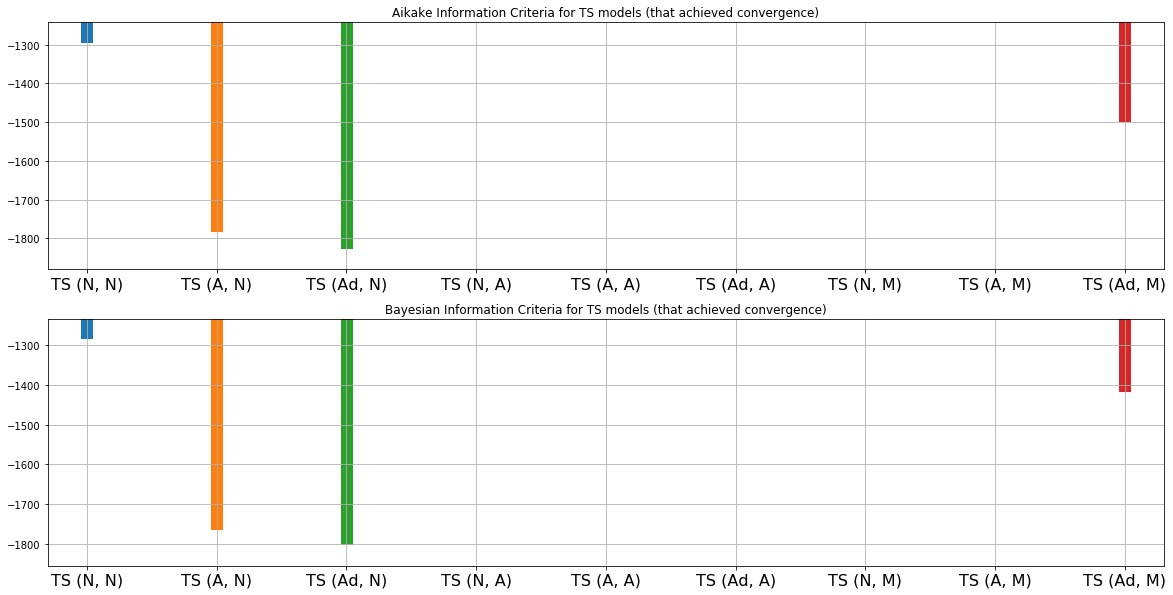

In [78]:
plt.figure(figsize=(20,10))

params = {'legend.fontsize': 15,
          'legend.handlelength': 2}
plt.rcParams.update(params)

TS = [TS_NN, TS_AN, TS_AdN, TS_NA, TS_AA, TS_AdA, TS_NM, TS_AM, TS_AdM]

spacing = 0.05
barWidth = 0.1
r = np.arange(len(TS)) - (len(TS)/2)*spacing

plt.subplot(211)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].aic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].aic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Aikake Information Criteria for TS models (that achieved convergence)')
plt.grid()

plt.subplot(212)
TS_val = []
for i in np.arange(len(TS)):
    if(TS_print[i]):
        plt.bar(r[i], TS[i].bic,  width=barWidth, edgecolor='white', label=TS_str[i])
        TS_val.append(TS[i].bic)
plt.axis((r[0]-.3, r[8]+.3, min(TS_val)-0.1*(max(TS_val)-min(TS_val)), max(TS_val)+0.1*(max(TS_val)-min(TS_val))))
plt.xticks(r, TS_str, fontsize='16')
plt.title('Bayesian Information Criteria for TS models (that achieved convergence)')
plt.grid()
plt.show()

## Model Validation
    The previous Model Training section and the fitted values plot allows to understand which model is likely to perform better. The previous Model Selection section allows to understand which models achieved convergence. 
    This section will exploit the residuals obtained on one of the selected model, and allows to "validate" our choice.

In [132]:
# Pick you favourite's models
TS_model = 'TS (Ad, M)'
TS_model_forecast = TS_AdM_forecast

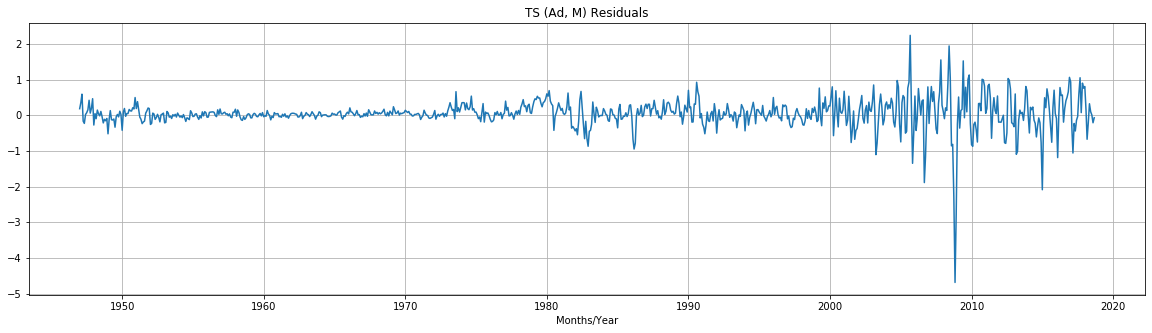

In [133]:
# Plot model residuals
model_fit = TS[TS_str.index(TS_model)]
df_res = pd.DataFrame({"resid": model_fit.resid}, index=df_train.index)
plt.figure(figsize=(20,5))
plt.plot(df_res.index, df_res.values)
plt.xlabel(xlab)
plt.title(TS_model +' Residuals')
plt.grid()
plt.show()

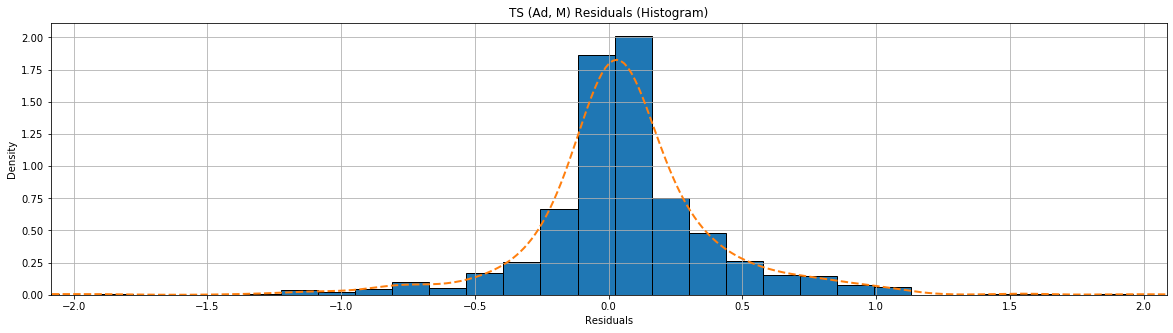

Mean: 0.048981
Variance: 0.165967


In [134]:
# Plot histogram
plt.figure(figsize=(20,5))
plt.title(TS_model + ' Residuals (Histogram)')
hist_res = df_res['resid'].hist(bins=50, normed=1, edgecolor='black')
df_res['resid'].plot(kind='kde', linewidth=2, linestyle='--')
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.8, r'$\mu = $'+ str(round(np.mean(df_res), 6)))
#plt.text(np.std(df_res.values), hist_res.get_ylim()[1]*0.75, r'$\sigma^2 = $' + str(round(np.var(df_res), 6)))
plt.xlabel('Residuals')
limX = np.mean(df_res.values)+5*np.std(df_res.values);
plt.xlim((-limX, limX))
plt.grid()
plt.show()

print ("Mean: %.6f" % np.mean(df_res))
print ("Variance: %.6f" % np.var(df_res))

## Normality test

### Kurtosis and Kurtosis Test
    Compute the kurtosis (Fisher or Pearson) of a dataset.
    Kurtosis is the fourth central moment divided by the square of the variance. If Fisher's definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution. If bias is False then the kurtosis is calculated using k statistics to eliminate bias coming from biased moment estimators

    Test whether a dataset has normal kurtosis.
    This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution: kurtosis = 3(n-1)/(n+1).

In [135]:
k, kpval = kurtosistest(df_res['resid'].values)
kurtosis_val = kurtosis(df_res['resid'].values, fisher=True)
# If Fisher’s definition is used, then 3.0 is subtracted from the result to give 0.0 for a normal distribution.
print("Kurtosis Test")
print("Statistic: %.4f" % k)
print("p-value: %.4f" % kpval)
print("Kurtosis value: %.4f" % kurtosis_val)

Kurtosis Test
Statistic: 16.0386
p-value: 0.0000
Kurtosis value: 27.6580


### Skew and Skewness Test
    Compute the skewness of a data set.
    For normally distributed data, the skewness should be about 0. For unimodal continuous distributions, a skewness value > 0 means that there is more weight in the right tail of the distribution. The function `skewtest` can be used to determine if the skewness value is close enough to 0, statistically speaking.

    Test whether the skew is different from the normal distribution.
    This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

In [136]:
s, spval = skewtest(df_res['resid'].values)
skew_val = skew(df_res['resid'].values)
print("Skew Test")
print("Statistic: %.4f" % s)
print("p-value: %.4f" % spval) 
print("Skewness value: %.4f" % skew_val) 

Skew Test
Statistic: -17.5690
p-value: 0.0000
Skewness value: -2.3281


### Jarque-Bera test
    Perform the Jarque-Bera goodness of fit test on sample data.
    The Jarque-Bera test tests whether the sample data has the skewness and kurtosis matching a normal distribution.

In [137]:
jb, jbpval= stats.jarque_bera(df_res['resid'].values)
print("Jarque-Bera Test")
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

Jarque-Bera Test
Statistic: 28220.8008
p-value: 0.0000


### Kolmogorov-Smirnov test
    Perform the Kolmogorov-Smirnov test for goodness of fit.
    This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either 'two-sided' (default), 'less' or 'greater'. The KS test is only valid for continuous distributions.

In [138]:
ks, kspval = stats.kstest(df_res['resid'].values, 'norm')
print("Kolmogorov-Smirnov Test")
print("Statistic: %.4f" % ks)
print("p-value: %.4f" % kspval) 

Kolmogorov-Smirnov Test
Statistic: 0.3016
p-value: 0.0000


## Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)

In [139]:
lm, lmpval, fval, fpval = het_arch(df_res['resid'].values)
print('Lagrange multiplier test statistic')
print("LM Statistic: %.4f" % lm)
print("LM-Test p-value: %.4f" % lmpval)
print('')
print('fstatistic for F test')
print("F Statistic: %.4f" % fval)
print("F-Test p-value: %.4f" % fpval)
print('')

Lagrange multiplier test statistic
LM Statistic: 217.0338
LM-Test p-value: 0.0000

fstatistic for F test
F Statistic: 13.5705
F-Test p-value: 0.0000



## Test for No Autocorrelation

### Brock–Dechert–Scheinkman test
    Calculate the BDS test statistic for independence of a time series

In [140]:
# Computing BDS
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df_res['resid'].values, max_dim=6);
print("BDS Test")
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

BDS Test
Dim 2: z-static 13.7005 Prob 0.0000
Dim 3: z-static 16.1481 Prob 0.0000
Dim 4: z-static 17.0783 Prob 0.0000
Dim 5: z-static 18.0330 Prob 0.0000
Dim 6: z-static 18.9963 Prob 0.0000


### Box-Pierce and Ljung-Box tests
    Ljung-Box and Box-Pierce statistic differ in their scaling of the autocorrelation function. Ljung-Box test is reported to have better small sample properties.

In [141]:
maxLags = 21
lbvalue, pvalue, bpvalue, bppvalue = acorr_ljungbox(df_res['resid'].values, lags = range(1, maxLags), boxpierce=True)

index = pd.MultiIndex.from_product([range(1, maxLags)], names=['lags'])
columns = pd.MultiIndex.from_product([['Box-Pierce', 'Ljung-Box'], ['Stats', 'p-value']], names=['Test', 'Statistics'])
data = np.array([bpvalue, bppvalue, lbvalue, pvalue])

boxTests = pd.DataFrame(data.T, index=index, columns=columns)
boxTests

Test        Box-Pierce                 Ljung-Box              
Statistics       Stats       p-value       Stats       p-value
lags                                                          
1           217.537939  3.114837e-49  218.296792  2.127664e-49
2           223.517921  2.908708e-49  224.304620  1.962775e-49
3           224.670427  1.963676e-48  225.463843  1.322941e-48
4           225.525266  1.212859e-47  226.324666  8.161048e-48
5           230.861535  6.990882e-48  231.704574  4.611292e-48
6           238.791122  1.017156e-48  239.708356  6.479105e-49
7           244.008519  5.217970e-49  244.980736  3.240926e-49
8           247.593697  5.575136e-49  248.607945  3.398579e-49
9           248.169590  2.428579e-48  249.191273  1.478056e-48
10          248.840493  9.514815e-48  249.871636  5.775844e-48
11          248.937830  4.662438e-47  249.970462  2.834026e-47
12          261.708953  4.922317e-49  262.952181  2.706555e-49
13          263.996936  7.871180e-49  265.280636  4.253876e-49
14          264.828544  2.440433e-48  266.127952  1.312077e-48
15          278.741772  1.437354e-50  280.320761  6.768908e-51
16          288.133174  7.272116e-52  289.912217  3.118354e-52
17          294.234227  1.740561e-52  296.150616  7.007254e-53
18          296.066407  3.099580e-52  298.026263  1.225993e-52
19          296.092248  1.263687e-51  298.052749  5.013173e-52
20          296.574391  4.044390e-51  298.547505  1.600046e-51

### QQplot
    Q-Q plot of the quantiles of x versus the quantiles/ppf of a distribution.
    Can take arguments specifying the parameters for dist or fit them automatically.

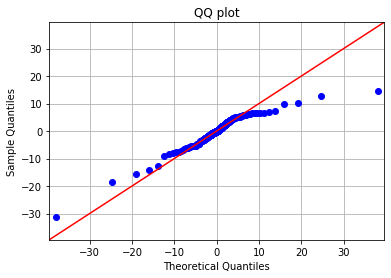

In [142]:
qqplot(df_res['resid'].values, stats.t, fit=True, line='45')
plt.title('QQ plot');
plt.grid()
plt.show()

### Plot Auto-correlation and Partial Auto-correlation functions
    Plots lags on the horizontal and the correlations on vertical axis.

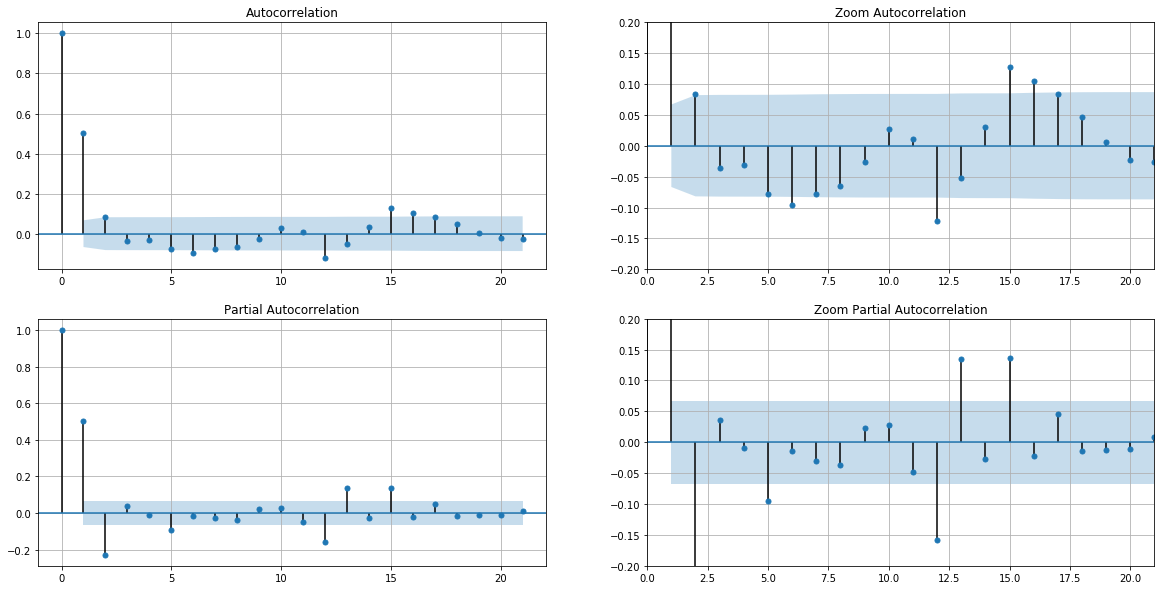

In [146]:
fig = plt.figure(figsize=(20,10))

# Auto-correlation function
ax1 = fig.add_subplot(221)
ax1.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax1)
ax2 = fig.add_subplot(222)
ax2.grid()
sm.graphics.tsa.plot_acf(df_res['resid'].values, lags=maxLags, ax=ax2, title = 'Zoom Autocorrelation')
ax2.axis((0, maxLags, -0.2, 0.2))

# Partial auto-correlation function
ax3 = fig.add_subplot(223)
ax3.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax3);
ax4 = fig.add_subplot(224)
ax4.grid()
sm.graphics.tsa.plot_pacf(df_res['resid'].values, lags=maxLags, ax=ax4, title = 'Zoom Partial Autocorrelation')
ax4.axis((0, maxLags, -0.2, 0.2));

plt.show()

# Model Prediction

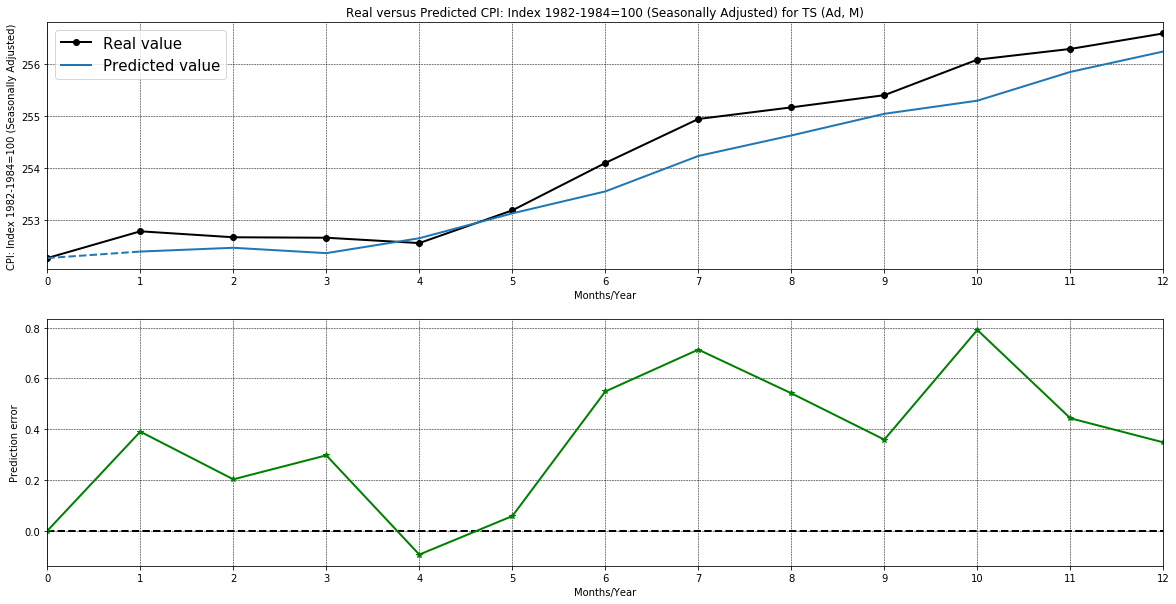

TS (Ad, M)
Prediction for 1 Months/Year: MAE = 0.39 (0.15%)
Prediction for 3 Months/Year: MAE = 0.3 (0.15%)
Prediction for 12 Months/Year: MAE = 0.4 (0.55%)


In [150]:
cmap = plt.get_cmap("tab10")

plt.figure(figsize=(20,10))
plt.subplot(211)
plt.title('Real versus Predicted ' + ylab + ' for ' + TS_model) 
plt.plot(range(0, stepsToForecast[-1]+1), np.concatenate((df_train.values[-1], df_test.values.flatten()), axis=0), 'k-o', linewidth=2)
plt.plot(range(1, stepsToForecast[-1]+1), TS_model_forecast, color = cmap(0), linewidth=2)
plt.plot([0,1], [df_train.values[-1][0], TS_model_forecast[0]], '--', color = cmap(0), linewidth=2)

plt.xlim([0,len(TS_model_forecast)])
plt.xticks(np.arange(0, len(TS_model_forecast)+1, step=1))
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.xlabel(xlab)
plt.ylabel(ylab)
plt.legend(['Real value', 'Predicted value'])

plt.subplot(212)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)
plt.plot(range(0, stepsToForecast[-1]+1), np.concatenate((np.array([0]), df_test.values.flatten()-TS_model_forecast), axis=0), 'g-*', linewidth=2)
plt.xticks(np.arange(0, len(TS_model_forecast)+1, step=1))
plt.xlim([0,len(TS_model_forecast)])
plt.xlabel(xlab)
plt.ylabel('Prediction error')
plt.grid(color='k', linestyle='--', linewidth=.5)
plt.show()

print(TS_model)
mae  = horizon_mae(df_test.values, TS_model_forecast, stepsToForecast)
mape = horizon_mape(df_test.values, TS_model_forecast, stepsToForecast)
for i in np.arange(len(stepsToForecast)):
    print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
          + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )

In [149]:
# Forecasted values of ETS model
TS_model_forecast

array([252.38650303, 252.45924272, 252.35579523, 252.64360776,
       253.1230988 , 253.54628474, 254.22937479, 254.62535675,
       255.04293648, 255.29593982, 255.85075832, 256.24468054])

## Model Prediction Overview
    Compare: Fitted values of the model with the training data
             Predicted values of the model with the testing data
      
    This section allows to see the forecast of the model that was selected and validated, but also to compare it against other models.

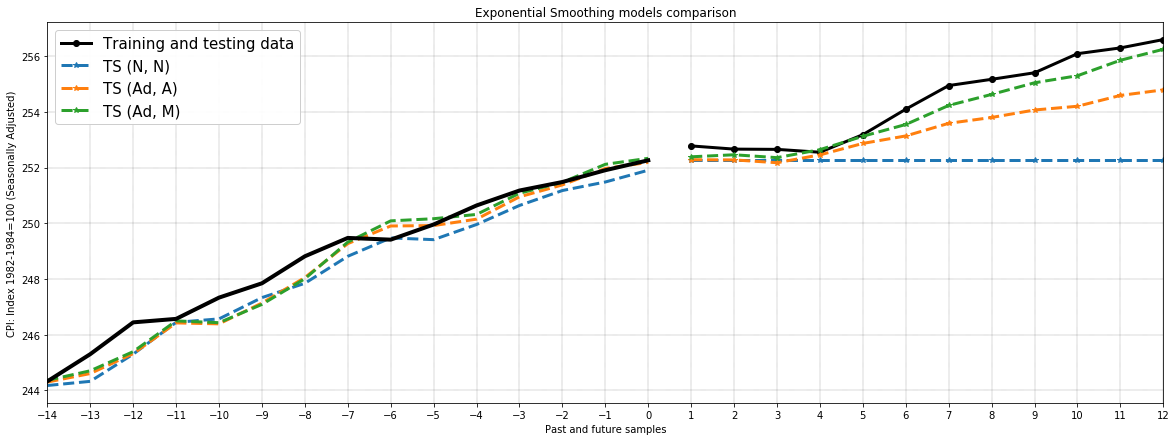

TS (N, N)
Prediction for 1 Months/Year: MAE = 0.52 (0.2%)
Prediction for 3 Months/Year: MAE = 0.44 (0.17%)
Prediction for 12 Months/Year: MAE = 2.11 (0.82%)

TS (Ad, A)
Prediction for 1 Months/Year: MAE = 0.49 (0.2%)
Prediction for 3 Months/Year: MAE = 0.45 (0.18%)
Prediction for 12 Months/Year: MAE = 1.02 (0.4%)

TS (Ad, M)
Prediction for 1 Months/Year: MAE = 0.39 (0.15%)
Prediction for 3 Months/Year: MAE = 0.3 (0.12%)
Prediction for 12 Months/Year: MAE = 0.4 (0.16%)



In [186]:
# Select from 
# TS_str = ['TS (N, N)', 'TS (A, N)', 'TS (Ad, N)', 
#           'TS (N, A)', 'TS (A, A)', 'TS (Ad, A)', 
#           'TS (N, M)', 'TS (A, M)', 'TS (Ad, M)']
TS_labels = ['Train and Test data', 
             'TS (N, N)',
             'TS (Ad, A)',
             'TS (Ad, M)']
plt.figure(figsize=(20,7))
plt.title('Exponential Smoothing models comparison')
plt.plot(1+np.arange(stepsToForecast[-1]), df_test.values, 'k-o' , linewidth = 3, label='Training and testing data')
plt.legend(TS_labels, loc='upper left')
for i in np.arange(len(TS_labels)-1):
    ETS_plot = plt.plot(1+np.arange(stepsToForecast[-1]), TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), '--*' , linewidth = 3, label = TS_labels[i+1] )
    plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, TS[TS_str.index(TS_labels[i+1])].fittedfcast[-previousStepsToShow-1:-1], '--' , linewidth = 3, color=ETS_plot[0].get_color())
plt.legend(loc='upper left', framealpha=0.95)
plt.plot(1+np.arange(previousStepsToShow)-previousStepsToShow, df_train.values[-previousStepsToShow:], 'k', linewidth = 4 )
plt.grid(color='k', linestyle='--', linewidth=.2)
plt.xlim([1-previousStepsToShow, stepsToForecast[-1]])
plt.xticks(1+np.arange(-previousStepsToShow, stepsToForecast[-1]))
plt.xlabel('Past and future samples')
plt.ylabel(ylab)
plt.show()

for i in np.arange(len(TS_labels[1:])):
    mae  = horizon_mae(df_test.values, TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), stepsToForecast)
    mape = horizon_mape(df_test.values, TS[TS_str.index(TS_labels[i+1])].forecast(stepsToForecast[-1]), stepsToForecast)
    print(TS_labels[i+1])
    for i in np.arange(len(stepsToForecast)):
        print('Prediction for ' + str(stepsToForecast[i]) + ' ' + xlab + ': MAE = ' \
              + str(round(mae[i], 2)) + ' (' + str(round(mape[i], 2)) + '%)' )
    print("")